**CONTENT**

The calibration process is slightly different for the spatial model. In this notebook we will first explore the various challenges and options concerning calibration of the spatial model. Besides that, this is the scratch environment for the creation of new functions, if need be.

**OPEN TASKS**

*short term*  
1. Think about another way to downgrade the number of contacts (which is now done with the `prevention` parameter). Or as Tijs says it:
>die 'downgrade' de contacten omdat slechts 1/3 contacten tot transmissie lijkt te leiden. Dit wil ik zelf wegdoen in een volgende modelversie omdat hier ook het effect van het weer inzit ed. Als je een andere oplossing kan bedenken is die meer dan welkom. Ik dacht eraan om bvb te spelen met de contactintensiteiten in de modellen (bvb calibratie op enkel 5 min plus) of tijdens de lockdown alle contacten eruit onder 1h in lengte. Die optie zit in de contact matrix inlaadfunctie.
2. Aggregate Belgian arrondissements in three regions: metropolitan, urban and rural
3. ~~Fix the model attributes to be `parameters` again (rather than taking 29 individual parameters), because this structure is used in the `MLE` function. Just put this restructuring of `parameters` dictionary in the save and open functions. Otherwise this will never work.~~
4. CURRENT ERROR,
```
    operands could not be broadcast together with shapes (7,) (12,38)
```
is associated with the `obj` function in `pso.py`, which is associated with `func`, which is the `MLE` in our case. The map from `obj` to `x` cannot happen because `obj` and `x` do not have the same dimensions. Note that the second and third value (in this case 12 and 38) is different every time. *This is probably due to the stochastic model?*
5. Find an elegant way of varying over the initial conditions in order to find a proper calibration
    * Try $G$ different locations for the first exposure, and make sure there is an *overall* shift for fitting the initial date
    * Only vary over the major hubs (Antwerpen, Gent, Brussel) as first break-out location, and perhaps vary over the age of the initial infection (if this has any effect at all)
    * Manually choose the initial conditions based on data (but note that these data only show the detected cases, not necessarily the first cases)
6. CURRENT ERROR,
```
AssertionError: I don't believe that you want more dimensions than samples!
```

*long term*  
1. (...)

**OPEN QUESTIONS**

1. What are the parameters sigma_H_in and extraTime that the MCMC is running over?
    * `sigma_H_in` is the standard deviation of the data (that is estimated in the MLE as well); `extraTime` or `warmup` is the delay in time between the simulation and the data (this is virtually the same as varying over different initial conditions)
2. What does `emcee.Ensemblesampler` do exactly? Reference: [this link](https://emcee.readthedocs.io/en/stable/user/sampler/)
3. Is it fair to start with an initialised model and only shift it horizontally? Isn't it possible to also run an MCMC on different initialisations?
    * Yes, that is possible, but it appears that this does not make a difference
4. What goes wrong when executing `fit_pso`? Arguably the model is not good.
5. Would it be useful to use constraining functions in the PSO optimisation?
6. What is the effect of using other `objective_fcn`s? Instead of `MLE` use `SSE`, for example. Are these 'choices', or is there a strong preference/necessity for one?
>An explanation of the difference between SSE and MLE can be found [here](https://emcee.readthedocs.io/en/stable/tutorials/line/). Brief summary: if measurement noise is unbiased, Gaussian and independent than the MLE and SSE are identical.

7. The example use in the function description of `MLE` function says `MLE(model,thetas,data,parNames,positions)`, but this does not correspond to the look of the function itself (`def MLE(thetas,BaseModel,data,states,parNames,samples=None):`). Is this some Python magic?
    * Probably this is just old?
8. PROBLEM -- For full calibration of every arrondissement *I will quite certainly need supercomputer time*. To calculate the maximum likelihood, a simulation is made every time. For 43 arrondissements and 5000 MCMC steps this means that on my pc this will need at least 20 hours to run. This problem **cannot** be circumvented by aggregating results, because this only happens a posteriori.
9. PROBLEM -- As Tijs mentioned, it is difficult to define initial conditions in the calibration code that will work for the spatial model nicely. We have time series for every arrondissement and we have a model that predicts time series for every arrondissement, but any of those arrondissement time series is dependent on the initial conditions in *every* arrondissement, which is essentially a guess at this moment. A fit over any of the time series must be a best-fit of all time series at the same time, with the ideal combination of 43 initial conditions. This doesn't sound desirable, **but perhaps ...**
    * What if the only varying initial condition is *where* we put the first exposed individual, combined with an overall translation (`extraTime`) and killing off all the 'dead paths' in the simulation (because it *didn't* die off)
    * 
10. What does `obj = partial(_obj_wrapper, func, args, kwargs)` on `pso.py` line 112 do exactly?
11. I believe there might be a factor $2\pi$ missing in the definition of the MLE

**Meeting with Jenna**
1. MLE line 147 should be changed to my situation: this is where we want to be!
2. Run over all places instead of all some states
3. Add extra parameter to MLE function
4. Make deterministic function from stochastic function

# Load packages

In [ ]:
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.models.utils import name2nis, save_sim, open_sim
from covid19model.data import model_parameters #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import social_policy_func

# Download function for complete calibration
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Explore `0.1-twallema-calibration-stochastic.ipynb`

*Steps*  
1. Hospitalisation data from 15-21 March is taken
2. Parameters that are being varied over are `sigma_H_in`, `extraTime` and `beta`. `sigma_H_in` is the uncertainty on `H_in`, `extraTime` is the time between day 0 of the initialised simulation (with e.g. E=10 people) and day 0 of the time series. Not sure if I like this.
3. Bounds for flat priors are given
4. Particle Swarm Optimisation (`MCMC.fit_pso`) is executed to find the maximum likelihood estimates of model parameters mentioned above
5. Resulting extraTime is added as model attribute and the other parameter values are used as initial values for the MCMC (typically: four slightly different initial points (nwalkers)). The MCMC happens in two dimensions with four walkers  (paths)
6. Ensemble sampler is used from the `emcee` sampler. I'm not entirely sure what this means
7. It appears that the beta parameter is *first* calibrated, and only *later on* the compliance parameters. The reason is that beta is best calibrated to data before any measures ('pure beta')

# Explore `run_optimization.py`

This function summarises much of the notebook described above. Difference between `full_calibration_wave1` and `full_calibration_wave2` is that the first one focuses on the March/April wave, whilst the latter focuses on the October/November wave.

**input**
Contains a function called `full_calibration_wave1` that takes in the following arguments:
1. `model`: initialised model object (such as the output of the `COVID19_SEIRD_sto_spatial` function)
2. `timeseries`: `pandas` Series Sciensano data to fit with date in index. Take from private data (if such is already available)
3. `spatial_unit`: name of the resulting files (e.g. Gent, Flanders, ...). Simply for *naming*
4. `start_date`: YYYY-MM-DD string for first day in the data to fit on
5. `end_beta`: YYYY-MM-DD string for last day to fit beta on
6. `end_ramp`: YYYY-MM-DD string for last day to fit compliance parameters on
7. `fig_path`: directory to save output figures in
8. `samples_path`: directory to save samples in. This is of the shape
```
    samples_dict={'calibration_data':states[0][0], 'start_date':start_date,
                  'end_beta':end_beta, 'end_ramp':end_ramp,
                  'maxiter': maxiter, 'popsize':popsize, 'steps_mcmc':steps_mcmc,
                  'R0':R0, 'R0_stratified_dict':R0_stratified_dict,
                  'lag_time': lag_time, 'beta': samples_beta['beta'],
                  'l': flat_samples_ramp[:,1].tolist(),'tau':flat_samples_ramp[:,2].tolist(),
                  'prevention':flat_samples_ramp[:,3].tolist()}
```
9. `initN`: total initial population
10. `Nc_total`: total interaction matrix
11. `maxiter`: maximal number of particle swarm steps
12. `popsize`: maximal number of particles in the swarm
13. `steps_mcmc`: iterations of the Monte Carlo simulation. 5000 steps in the national model takes about half an hour. Default is 10000

**output**

**notes**
1. `H_in` is hardcoded: if we want to choose e.g. the number of exposed people we need to fill in another string value here
2. Prior bounds of the PSO are hardcoded and may be adjusted (but probably these boundaries are wide enough)
3. PSO optimisation happens with the `fit_pso` function in `MCMC.py`, which contains all aid functions for executing the Markov Chain Monte Carlo simulation. `fit_pso` basically addresses the main function in `pso.py` called `optim`: it *only* takes the first return value of this function, which is needed for the MCMC. Description of `fit_pso`:
```
    A function to compute the mimimum of the absolute value of the maximum likelihood estimator using a particle swarm optimization
```
it must take in a certain function and boundaries for the function's varied parameters. 
4. The function this particle swarm attempts to minimize is called `MLE` in the module `objective_fcns.py`:
```
    A function to return the maximum likelihood estimator given a model object and a dataset
```
5. The args given to the `optim` function are "additional arguments passed to objective and constraint functions". They are
```
    args=(model,data,states,parNames,samples)
```
6. Additional arguments are hardcoded and not very important:
```
    processes=mp.cpu_count()-1),minfunc=1e-9, minstep=1e-9,debug=True, particle_output=True
```
`multiprocessing.cpu_count()-1` returns the number of processors in the system minus 1. If there are more than two processors, some fancy `multiprocessing.Pool` object is created (computer stuff)  

7. What happens to the `args` arguments (model,data,states,parNames,samples) in `fit_pso`?
    * They run through `functools`'s `partial` function, which fixes some function arguments:
    >The partial() is used for partial function application which “freezes” some portion of a function’s arguments and/or keywords resulting in a new object with a simplified signature. For example, partial() can be used to create a callable that behaves like the int() function where the base argument defaults to two
    * The effect here is that the arguments `args` are fixed to the `MLE` function, so in effect `MLE(args)` is executed. QUESTION: why this detour? Code-technical stuff.
    * No constraining functions are given, so "No constraints given" is printed.
    * `is_feasible = partial(_is_feasible_wrapper, cons)` checks whether no additional constraints are violated. In our case, this is always `True`
    * Then the actual PSO is coded (raw) and returns a coordinate array of "The swarm's best known position (optimal design)"
7. **the secret is in the `MLE` function**, which takes as arguments `model, data, states, parNames, samples`:
> A function to return the maximum likelihood estimator given a model object and a dataset

    * returns the total sum of squared errors, which is why it is minimised!
    * In the first step, updates the parameters to initial guesses. In the special case where the parameter is called `extraTime`, the model attribute `extraTime` is set to its value (rather than a parameter in the `parameter` attribute)
    * the `extraTime` magic happens at line 130: `T = max(data_length)+BaseModel.extraTime-1`

# Build Notebook from Jenna's example

## Load required packages

In [1]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import datetime
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, lockdown_func, policies_until_september

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Get public data (per province)

In [2]:
raw_hosp_data = pd.read_csv('../../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])

timeseries = pd.pivot_table(raw_hosp_data, index='DATE', values='NEW_IN', aggfunc=np.sum)['NEW_IN']

## Load model data

In [3]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial='prov')

# Final directory can be national, provinces or arrondissements
fig_path = '../../results/calibrations/COVID19_SEIRD/provinces/'
# Directory below model_parameters can be COVID19_SEIRD, COVID19_SEIRD_sto, COVID19_SEIRD_spatial or COVID19_SEIRD_spatial_sto
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD_spatial/calibrations/provinces/'



## Model initialisation

In [4]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params_wave1 = model_parameters.get_COVID19_SEIRD_parameters(spatial='prov')
params_wave1.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})

# Initial states: single 30 year old exposed individual per province
initE = np.zeros(initN.shape)
for gg in range(initN.shape[0]):
    initE[gg][3] = 1
initial_states = {'S': initN, 'E': initE}

# Initiate model
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params_wave1, time_dependent_parameters={'Nc': lockdown_func}, spatial='prov')

## Define plot functions

In [26]:
def plot_simulations(start_date, end_ramp, end_date, model, samples_dict, timeseries, 
                    spatial_unit, n_lines=200, save=False, spatial=False):

    states = [['H_in']]
    data=[timeseries[start_date:end_ramp].values]

    fig,ax=plt.subplots()
    for i in range(n_lines):
        idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
        if 'l' in model.parameters.keys():
            idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
            model.parameters['tau'] = samples_dict['tau'][idx]
            model.parameters['prevention'] = samples_dict['prevention'][idx]
        y_model = model.sim(time=end_date, warmup=samples_dict['warmup'], start_date=start_date)
        ax = plot_fit(y_model,data,start_date,samples_dict['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05}, spatial=True)
    
    # plot mean line
    model.parameters['beta'] = np.mean(samples_dict['beta'])
    if 'l' in model.parameters.keys():
        model.parameters['l'] = np.mean(samples_dict['l'])
        model.parameters['tau'] = np.mean(samples_dict['tau'])
        model.parameters['prevention'] = np.mean(samples_dict['prevention'])
    y_model = model.sim(time=end_date, warmup=samples_dict['warmup'], start_date=start_date)
    if spatial:
        ax.plot(y_model['time'],y_model['H_in'].sum(dim='Nc').sum(dim='place'), c='green', linestyle='--', lw=2, alpha=0.5)
    else:
        ax.plot(y_model['time'],y_model['H_in'].sum(dim='Nc'), c='green', linestyle='--', lw=2, alpha=0.5)
    
    data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
    plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
    legend_text=['daily \nhospitalizations']
    ax.set_xlim(start_date, end_date)
    fig.tight_layout()
    if save==True:
        fig.savefig(fig_path+spatial_unit +'_'+str(datetime.date.today())+'.pdf',bbox_inches='tight', dpi=600)
    return

## Calibration on first wave

In [6]:
## First wave
start_date = '2020-03-15'
end_beta = '2020-03-25'
end_ramp = '2020-05-23'#'2020-05-23'

In [7]:
# Data points for calibration of beta
len(timeseries.loc[start_date:end_beta])

11

In [8]:
# Data points for calibration of compliance parameters
len(timeseries.loc[end_beta:end_ramp])

60

In [9]:
# spatial_unit = 'prov_wave1_sum'

# samples_dict = full_calibration_wave1(model_wave1, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
#                                 fig_path=fig_path, samples_path=samples_path,
#                                 initN=initN, Nc_total=Nc_total,
#                                 maxiter=100, popsize=100, steps_mcmc=1000)#popsize decreased to 100

Using all but one logical processors

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [7.32816244e+01 5.76561151e+01 3.23051903e-02] 50.7287621947661
Best after iteration 2: [7.32816244e+01 5.76561151e+01 3.23051903e-02] 50.7287621947661
Best after iteration 3: [7.32816244e+01 5.76561151e+01 3.23051903e-02] 50.7287621947661
New best for swarm at iteration 4: [5.09879430e+01 5.57311490e+01 3.32210224e-02] 50.226774752985186
Best after iteration 4: [5.09879430e+01 5.57311490e+01 3.32210224e-02] 50.226774752985186
Best after iteration 5: [5.09879430e+01 5.57311490e+01 3.32210224e-02] 50.226774752985186
Best after iteration 6: [5.09879430e+01 5.57311490e+01 3.32210224e-02] 50.226774752985186
New best for swarm at iteration 7: [5.38629698e+01 5.64231794e+01 3.35089816e-02] 49.778193478025116
Best after iteration 7: [5.38629698e+01 5.64231794e+01 3.35089816e-02] 49.7781934780251

New best for swarm at iteration 63: [5.33090661e+01 4.72647694e+01 3.87648463e-02] 49.13729301209373
Best after iteration 63: [5.33090661e+01 4.72647694e+01 3.87648463e-02] 49.13729301209373
New best for swarm at iteration 64: [5.30420080e+01 4.74965780e+01 3.87609594e-02] 49.13652028473567
Best after iteration 64: [5.30420080e+01 4.74965780e+01 3.87609594e-02] 49.13652028473567
Best after iteration 65: [5.30420080e+01 4.74965780e+01 3.87609594e-02] 49.13652028473567
New best for swarm at iteration 66: [5.29801110e+01 4.74978104e+01 3.87622782e-02] 49.13641095575962
Best after iteration 66: [5.29801110e+01 4.74978104e+01 3.87622782e-02] 49.13641095575962
New best for swarm at iteration 67: [5.28969418e+01 4.74496740e+01 3.87608968e-02] 49.136355258705635
Best after iteration 67: [5.28969418e+01 4.74496740e+01 3.87608968e-02] 49.136355258705635
Best after iteration 68: [5.28969418e+01 4.74496740e+01 3.87608968e-02] 49.136355258705635
Best after iteration 69: [5.28969418e+01 4.74496740e+

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:37:31<00:00,  9.41s/it]


Use this estimate with caution and run a longer chain!
---------------------------------------------------------------------------------------------------------

CALIBRATING COMPLIANCE RAMP
---------------------------

1) Particle swarm optimization


2) Markov-Chain Monte-Carlo sampling

No constraints given.
New best for swarm at iteration 1: [100.          12.86035446   0.           0.27690625] 337.08221486279916
Best after iteration 1: [100.          12.86035446   0.           0.27690625] 337.08221486279916
Best after iteration 2: [100.          12.86035446   0.           0.27690625] 337.08221486279916
New best for swarm at iteration 3: [85.37064591 12.23385288  0.          0.34370386] 323.93417215726953
Best after iteration 3: [85.37064591 12.23385288  0.          0.34370386] 323.93417215726953
New best for swarm at iteration 4: [87.58602971 13.31725463  0.          0.31243488] 323.4964664050871
Best after iteration 4: [87.58602971 13.31725463  0.          0.31243488] 323.49646640

Best after iteration 64: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 65: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 66: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 67: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 68: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 69: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 70: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
Best after iteration 71: [43.43719417 11.30069152  0.          0.34924255] 299.53433317876534
New best for swarm at iteration 72: [43.6228246  11.28814908  0.          0.34906793] 299.5247089318138
Best after iteration 72: [43.6228246  11.28814908  0.          0.34906793] 299.5247089318138
Best after iteration 73: [43.6228246  11.28814908  

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\mrollier\AppData\Roaming\Python\Python37\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [7:28:12<00:00, 28.56s/it]


---------------------------------------------------------------------------------------------------------

DONE

SAMPLES DICTIONARY SAVED IN "../../data/interim/model_parameters/COVID19_SEIRD_spatial/calibrations/provinces/prov_wave1_sum_2020-11-20.json"


<IPython.core.display.Javascript object>


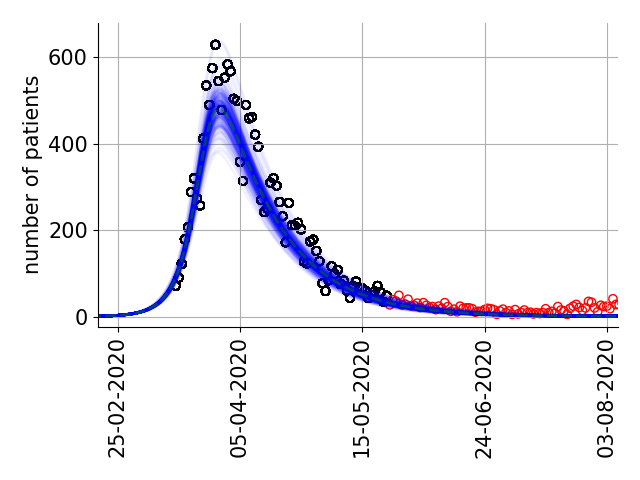

In [28]:
# Took 22 minutes!
# end_date = '2020-09-01'
# plot_simulations(start_date, end_ramp, end_date, model_wave1, samples_dict, timeseries, 
#                     spatial_unit, n_lines=200, save=False, spatial=True)

In [11]:
# Test
# samples_dict = full_calibration_wave1(model_wave1, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
#                                 fig_path=fig_path, samples_path=samples_path,
#                                 initN=initN, Nc_total=Nc_total,
#                                 maxiter=1, popsize=10, steps_mcmc=3, discard=0) # Very low numbers

Using all but one logical processors

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [5.63713766e+01 4.64938679e+01 3.87052315e-02] 53.43925662962468
Stopping search: maximum iterations reached --> 1

2) Markov-Chain Monte-Carlo sampling



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.60s/it]


---------------------------------------------------------------------------------------------------------

CALIBRATING COMPLIANCE RAMP
---------------------------

1) Particle swarm optimization


2) Markov-Chain Monte-Carlo sampling

No constraints given.
Best after iteration 1: [7.08090090e+01 1.15524689e+01 2.02302099e+00 2.80462525e-02] 366.61752030640207
Stopping search: maximum iterations reached --> 1


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\mrollier\AppData\Roaming\Python\Python37\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:09<00:00, 23.05s/it]
C:\Users\mrollier\AppData\Roaming\Python\Python37\site-packages\emcee\autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


---------------------------------------------------------------------------------------------------------

DONE

SAMPLES DICTIONARY SAVED IN "../../data/interim/model_parameters/COVID19_SEIRD_spatial/calibrations/provinces/prov_wave1_sum_2020-11-19.json"


# Scratches

In [6]:
from covid19model.optimization.run_optimization import calculate_R0
samples_beta = dict({'beta' : [0.0382, 0.0379, 0.0384]})

R0, R0_dict = calculate_R0(samples_beta, model_wave1, initN, Nc_total)

R0

[2.94191413924182, 2.918810101499082, 2.957316831070309]

In [14]:
processes = 16

import multiprocessing
mp_pool = multiprocessing.Pool(processes)